This notebook is about performance comparison for basic __map__ and __filter__ operators between Rocket.jl, Signals.jl and Reactive.jl

In [1]:
ENV["REACTIVE_CHANNEL_SIZE"] = 1000000

using Rocket
using BenchmarkTools
using Statistics

import Reactive
import Signals

In [2]:
const N = 1000;

In [3]:
# General function for Rocket.jl takes any operator as an argument and sync/async modes
function rocket_jl(operator; mode = ASYNCHRONOUS_SUBJECT_MODE)  
    source = make_subject(Int, mode = mode)
    mapped = source |> operator
    
    # It is also possible to use a KeepActor here, but lets use a lambda here to match with the others
    values = Vector{Int}() 
    actor  = sync(lambda(on_next = (d) -> push!(values, d)))
    
    subscribe!(mapped, actor)
    
    for i in 0:N
        next!(source, i)
    end
    complete!(source)
    
    wait(actor)
    
    return values
end;

#### Map operator

In [18]:
function reactive_jl_map()
    x = Reactive.Signal(0)
    mapped = Reactive.map(a -> a ^ 2, x)
    values = Vector{Int}()
    stored = Reactive.map(s -> push!(values, s), mapped)
    for i in 1:N
        push!(x, i)
    end
    yield()
    return values
end

function signals_jl_map()
    x = Signals.Signal(0)
    m = Signals.Signal(x -> x ^ 2, x)
    
    values = []
    Signals.when(Signals.Signal(true), m) do value
        push!(values, value)
    end
    
    for i in 1:N
        x(i)
        yield()
    end
    
    return values
end

squared_operator = map(Int, d -> d ^ 2);

In [19]:
reactive_map     = reactive_jl_map()
signals_map      = signals_jl_map()
rocket_map_async = rocket_jl(squared_operator, mode = ASYNCHRONOUS_SUBJECT_MODE)
rocket_map_sync  = rocket_jl(squared_operator, mode = SYNCHRONOUS_SUBJECT_MODE)

@assert reactive_map == rocket_map_async
@assert reactive_map == rocket_map_sync
@assert reactive_map == signals_map

In [6]:
bmap1 = @benchmark reactive_jl_map();

Signals.async_mode(true)
bmap2 = @benchmark signals_jl_map();

Signals.async_mode(false)
bmap3 = @benchmark signals_jl_map();

bmap4 = @benchmark rocket_jl($squared_operator, mode = ASYNCHRONOUS_SUBJECT_MODE);
bmap5 = @benchmark rocket_jl($squared_operator, mode = SYNCHRONOUS_SUBJECT_MODE);

In [7]:
println("Reactive.jl |         map | ", BenchmarkTools.prettytime(time(bmap1)))
println("Signals.jl  | async + map | ", BenchmarkTools.prettytime(time(bmap2)))
println("Signals.jl  | sync  + map | ", BenchmarkTools.prettytime(time(bmap3)))
println("Rocket.jl   | async + map | ", BenchmarkTools.prettytime(time(bmap4)))
println("Rocket.jl   | sync  + map | ", BenchmarkTools.prettytime(time(bmap5)))

Reactive.jl |         map | 905.097 μs
Signals.jl  | async + map | 29.814 ms
Signals.jl  | sync  + map | 14.738 ms
Rocket.jl   | async + map | 213.926 μs
Rocket.jl   | sync  + map | 96.646 μs


#### Filter operator

In [8]:
function reactive_jl_filter()
    x = Reactive.Signal(0)
    mapped = Reactive.filter(a -> a % 2 == 0, x)
    values = Vector{Int}()
    stored = Reactive.map(s -> push!(values, s), mapped)
    for i in 1:N
        push!(x, i)
    end
    yield()
    return values
end

function signals_jl_filter()
    x = Signals.Signal(0)
    m = Signals.filter(x -> x % 2 == 0, 0, x)
    values = []

    Signals.when(Signals.Signal(true), m) do value
        push!(values, value)
    end
    
    for i in 1:N
        x(i)
        yield()
    end
    
    return values
end

even_operator = filter(x -> x % 2 == 0);

In [9]:
@assert reactive_jl_filter() == rocket_jl(even_operator, mode = ASYNCHRONOUS_SUBJECT_MODE)
@assert reactive_jl_filter() == rocket_jl(even_operator, mode = SYNCHRONOUS_SUBJECT_MODE)
@assert reactive_jl_filter() == signals_jl_filter()

In [10]:
bfilter1 = @benchmark reactive_jl_filter();

Signals.async_mode(true)
bfilter2 = @benchmark signals_jl_filter();

Signals.async_mode(false)
bfilter3 = @benchmark signals_jl_filter();

bfilter4 = @benchmark rocket_jl($even_operator, mode = ASYNCHRONOUS_SUBJECT_MODE);
bfilter5 = @benchmark rocket_jl($even_operator, mode = SYNCHRONOUS_SUBJECT_MODE);

In [11]:
println("Reactive.jl |         filter | ", BenchmarkTools.prettytime(time(bfilter1)))
println("Signals.jl  | async + filter | ", BenchmarkTools.prettytime(time(bfilter2)))
println("Signals.jl  | sync  + filter | ", BenchmarkTools.prettytime(time(bfilter3)))
println("Rocket.jl   | async + filter | ", BenchmarkTools.prettytime(time(bfilter4)))
println("Rocket.jl   | sync  + filter | ", BenchmarkTools.prettytime(time(bfilter5)))

Reactive.jl |         filter | 877.080 μs
Signals.jl  | async + filter | 29.383 ms
Signals.jl  | sync  + filter | 13.907 ms
Rocket.jl   | async + filter | 215.260 μs
Rocket.jl   | sync  + filter | 100.872 μs


In [12]:
using StatsPlots

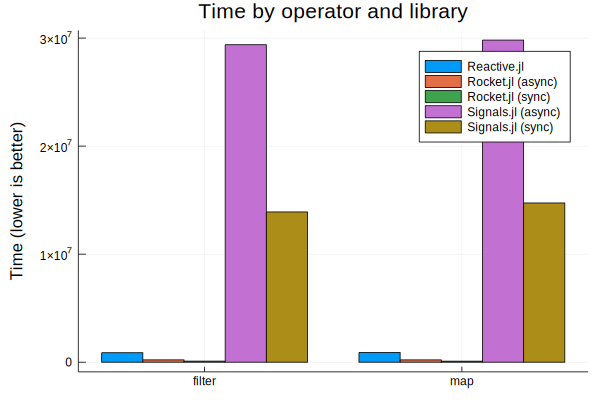

In [13]:
mn = [
    time(bmap1), time(bfilter1),
    time(bmap4), time(bfilter4),
    time(bmap5), time(bfilter5),
    time(bmap2), time(bfilter2),
    time(bmap3), time(bfilter3)
]
sx = repeat(["Reactive.jl", "Rocket.jl (async)", "Rocket.jl (sync)", "Signals.jl (async)", "Signals.jl (sync)"], inner = 2)
nam = repeat([ "map", "filter" ], outer = 5)

groupedbar(nam, mn, group = sx, ylabel = "Time (lower is better)", title = "Time by operator and library")

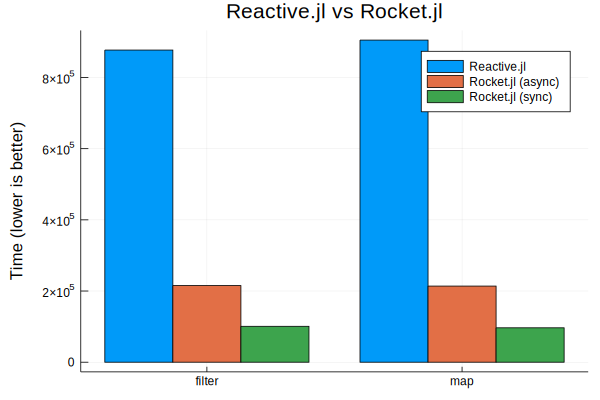

In [14]:
mn = [
    time(bmap1), time(bfilter1),
    time(bmap4), time(bfilter4),
    time(bmap5), time(bfilter5),
]
sx = repeat(["Reactive.jl", "Rocket.jl (async)", "Rocket.jl (sync)"], inner = 2)
nam = repeat([ "map", "filter" ], outer = 3)

p = groupedbar(nam, mn, group = sx, ylabel = "Time (lower is better)", title = "Reactive.jl vs Rocket.jl")

savefig("pics/reactive-rocket")

display(p)

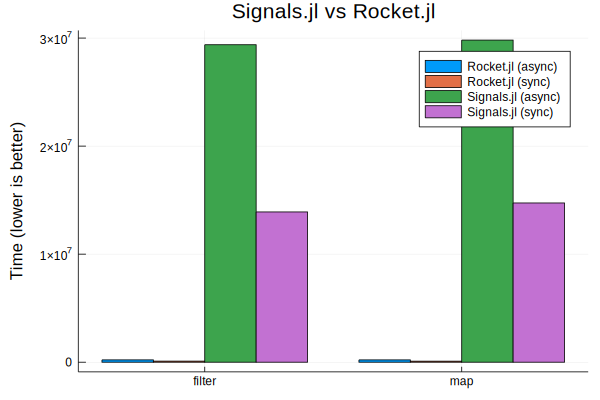

In [15]:
mn = [
    time(bmap4), time(bfilter4),
    time(bmap5), time(bfilter5),
    time(bmap2), time(bfilter2),
    time(bmap3), time(bfilter3)
]
sx = repeat(["Rocket.jl (async)", "Rocket.jl (sync)", "Signals.jl (async)", "Signals.jl (sync)"], inner = 2)
nam = repeat([ "map", "filter" ], outer = 4)

p = groupedbar(nam, mn, group = sx, ylabel = "Time (lower is better)", title = "Signals.jl vs Rocket.jl")

savefig("pics/signals-rocket")

display(p)